In [1]:
import torchvision.models as models
import torch.nn as nn

In [2]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17274, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 17274 (delta 1), reused 0 (delta 0), pack-reused 17270 (from 3)
Receiving objects: 100% (17274/17274), 16.12 MiB | 33.36 MiB/s, done.
Resolving deltas: 100% (11862/11862), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 16.8 MB/s eta 0:00:00a 0:00:01


In [3]:
import yaml

data = {
    'train': '/kaggle/input/defect-datw/train-20250312T172148Z-001/train/images',
    'val': '/kaggle/input/defect-datw/test-20250312T172147Z-001/test/images',
    'nc': 4,
    'names': ['Porosity', 'Overweld', 'Underfilled', 'Undercut']
}

with open('/kaggle/working/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=None)

In [ ]:
model_path = 'runs/detect/train2/weights/best.pt'
data_yaml_path= "/kaggle/working/data.yaml"
# Evaluate the model
model = YOLO(model_path)

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from torchcam.methods import SmoothGradCAMpp
from torchvision import models

# ✅ Load Pretrained DenseNet121 Model
model = models.densenet121(pretrained=True).eval()

# ✅ Function: Preprocess Image
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0), np.array(img)
    
def apply_gradcam(img_path, model):
    # Preprocess Image
    img_tensor, orig_img = preprocess_image(img_path)
    
    # Use Grad-CAM
    cam_extractor = SmoothGradCAMpp(model)
    model.zero_grad()
    scores = model(img_tensor)
    class_idx = scores.argmax().item()
    
    # Generate CAM heatmap
    activation_map = cam_extractor(class_idx, scores)

    # 🔹 Fix: Convert to tensor if it's a list
    if isinstance(activation_map, list):
        activation_map = activation_map[0]  # Take the first element

    heatmap = activation_map.squeeze().cpu().detach().numpy()  # Ensure correct shape

    # 🔹 Normalize Heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    return orig_img, heatmap



import cv2

def overlay_heatmap(orig_img, heatmap, colormap=cv2.COLORMAP_JET):
    # 🔹 Convert RGB to BGR for OpenCV compatibility
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)

    # 🔹 Ensure Heatmap is 1-Channel
    if len(heatmap.shape) > 2:
        heatmap = np.mean(heatmap, axis=0)  # Convert multi-channel to single grayscale

    # 🔹 Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))

    # 🔹 Normalize Heatmap
    heatmap = np.uint8(255 * (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8))

    # 🔹 Convert to 3-Channel for Coloring
    heatmap_color = cv2.applyColorMap(heatmap, colormap)

    # 🔹 Ensure both images have the same shape
    if heatmap_color.shape != orig_img.shape:
        heatmap_color = cv2.resize(heatmap_color, (orig_img.shape[1], orig_img.shape[0]))

    # 🔹 Overlay Heatmap on Original Image
    overlay_img = cv2.addWeighted(orig_img, 0.6, heatmap_color, 0.4, 0)
    
    return overlay_img

def show_results(img_path, model):
    orig_img, heatmap = apply_gradcam(img_path, model)
    overlay_img = overlay_heatmap(orig_img, heatmap)

    # 🔹 Plot Original, Heatmap, and Overlay Image
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(orig_img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(heatmap, cmap="jet")
    ax[1].set_title("Grad-CAM Heatmap")
    ax[1].axis("off")

    ax[2].imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Overlay Image")
    ax[2].axis("off")

    plt.show()


In [78]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
import torch.nn.functional as F

def apply_gradcam(img_path, model):
    # Preprocess Image
    img_tensor, orig_img = preprocess_image(img_path)
    
    # Ensure model is in evaluation mode
    model.eval()
    
    # Enable gradients for the input
    img_tensor.requires_grad_()

    # Use Grad-CAM
    cam_extractor = SmoothGradCAMpp(model)
    model.zero_grad()
    scores = model(img_tensor)

    # 🔹 Get predicted class and confidence
    probabilities = F.softmax(scores, dim=1)  # Convert logits to probabilities
    class_idx = probabilities.argmax().item()
    confidence = probabilities[0, class_idx].item()  # Confidence score
    
    # Generate CAM heatmap
    activation_map = cam_extractor(class_idx, scores)

    # 🔹 Fix: Convert to tensor if it's a list
    if isinstance(activation_map, list):
        activation_map = activation_map[0]  # Take the first element

    heatmap = activation_map.squeeze().cpu().detach().numpy()  # Ensure correct shape

    # 🔹 Normalize Heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    return orig_img, heatmap, class_idx, confidence


def overlay_heatmap(orig_img, heatmap, colormap=cv2.COLORMAP_JET):
    # 🔹 Convert RGB to BGR for OpenCV compatibility
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)

    # 🔹 Ensure Heatmap is 1-Channel
    if len(heatmap.shape) > 2:
        heatmap = np.mean(heatmap, axis=0) 
    # Normalize heatmap (ensure it’s between 0 and 255)
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap = np.uint8(255 * heatmap)  # Convert to uint8

# Ensure heatmap is single-channel grayscale (CV_8UC1)
    if len(heatmap.shape) == 3:  
       heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

# Apply colormap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
         # Convert multi-channel to single grayscale

    # 🔹 Resize heatmap to match original image size


    # 🔹 Ensure both images have the same shape
    if heatmap_color.shape != orig_img.shape:
        heatmap_color = cv2.resize(heatmap_color, (orig_img.shape[1], orig_img.shape[0]))

    # 🔹 Overlay Heatmap on Original Image
    overlay_img = cv2.addWeighted(orig_img, 0.6, heatmap_color, 0.4, 0)
    
    return overlay_img
    


def show_results(img_path, model, class_labels=None):
    orig_img, heatmap, class_idx, confidence = apply_gradcam(img_path, model)
    overlay_img = overlay_heatmap(orig_img, heatmap)

    # Get class label if provided
    predicted_label = class_labels[class_idx] if class_labels else f"Class {class_idx}"
    confidence_text = f"{predicted_label} ({confidence:.2%})"

    # 🔹 Plot Original, Heatmap, and Overlay Image
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(orig_img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(heatmap, cmap="jet")
    ax[1].set_title("Grad-CAM Heatmap")
    ax[1].axis("off")

    ax[2].imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
    ax[2].set_title(f"Overlay Image\n{confidence_text}")
    ax[2].axis("off")

    plt.show()


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics.engine.results import Results  # Ensure correct import

# Define target layer (adjust if needed)
target_layer = model.model.model[22].cv3[-1][1].conv

# Grad-CAM Class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output
    
    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_tensor, class_idx=None):
        # Forward pass
        output = self.model(input_tensor)

        if output is None:
            raise ValueError("Model output is None. Check the model's forward pass.")

        # Handle Ultralytics YOLO output
        if isinstance(output, Results):
            if output.probs is not None:
                output = output.probs  # Extract probability tensor
            elif output.boxes is not None:
                output = output.boxes.cls  # Get class indices from detected boxes
            else:
                raise ValueError("Model output does not contain probabilities or bounding boxes.")

        # Ensure tensor format
        if isinstance(output, list):
            output = torch.tensor(output, dtype=torch.float32)

        if not isinstance(output, torch.Tensor):
            raise TypeError(f"Expected torch.Tensor but got {type(output)}")

        # Determine class index
        if class_idx is None:
            class_idx = int(torch.mode(output.flatten())[0].item())  # Most frequent class

        # Zero gradients
        self.model.zero_grad()

        # Compute gradients
        grad_target_map = torch.zeros_like(output)
        grad_target_map[class_idx] = 1
        output.backward(gradient=grad_target_map)

        # Generate heatmap
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.sum(weights[:, np.newaxis, np.newaxis] * activations, axis=0)

        # Normalize heatmap
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

        return cam, class_idx
# Run Grad-CAM
gradcam = GradCAM(model, target_layer)
heatmap, predicted_class_idx = gradcam.generate_heatmap(input_tensor)

# Resize heatmap to match the input image size
heatmap = cv2.resize(heatmap, (input_image_cv.shape[1], input_image_cv.shape[0]))

# Apply colormap
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(input_image_cv, 0.6, heatmap_colored, 0.4, 0)

# Display Results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(input_image_cv, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Overlay Image (No Text)")

plt.show()

In [109]:
import cv2
import numpy as np

def overlay_heatmap(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlay heatmap on the original image without predicted class text.
    
    Parameters:
        image (numpy array): Original image
        heatmap (numpy array): Generated heatmap
        alpha (float): Opacity of the heatmap overlay
        colormap (int): OpenCV colormap for visualization

    Returns:
        overlaid_image (numpy array): Image with heatmap overlay
    """
    # Resize heatmap to match the input image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Normalize heatmap (0 to 255) for colormap
    heatmap = np.uint8(255 * heatmap)

    # Apply color mapping
    heatmap_colored = cv2.applyColorMap(heatmap, colormap)

    # Ensure proper color mapping (high activation = Red, low = Blue)
    heatmap_colored = cv2.applyColorMap(255 - heatmap, colormap)

    # Blend heatmap with original image
    overlaid_image = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlaid_image


In [106]:
import torch
import numpy as np
from ultralytics.engine.results import Results

def generate_heatmap(self, input_tensor, class_idx=None):
    # Forward pass
    output = self.model(input_tensor)

    if output is None:
        raise ValueError("Model output is None. Check the model's forward pass.")

    # Handle Ultralytics YOLO output
    if isinstance(output, Results):
        output = output.probs  # Extract probability tensor
        if output is None:
            raise ValueError("Model output does not contain probabilities. Ensure classification mode is used.")
    
    # Convert list output to tensor
    if isinstance(output, list):
        output = torch.tensor(output)  # Convert list to tensor

    if not isinstance(output, torch.Tensor):
        raise TypeError(f"Expected torch.Tensor but got {type(output)}")

    # Determine class index
    if class_idx is None:
        class_idx = torch.argmax(output).item()

    # Zero gradients
    self.model.zero_grad()

    # Compute gradients
    grad_target_map = torch.zeros_like(output)
    grad_target_map[0, class_idx] = 1
    output.backward(gradient=grad_target_map)

    # Generate heatmap
    gradients = self.gradients.cpu().data.numpy()[0]
    activations = self.activations.cpu().data.numpy()[0]
    weights = np.mean(gradients, axis=(1, 2))
    cam = np.sum(weights[:, np.newaxis, np.newaxis] * activations, axis=0)

    # Normalize heatmap
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

    return cam, class_idx, output[0, class_idx].item()


In [83]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
   

In [74]:
import yaml

# Load class names from data.yml
with open("data.yaml", "r") as file:
    data_config = yaml.safe_load(file)

class_names = data_config.get("names", [])  # Ensure it retrieves class labels

# Debug print
print(f"Loaded Class Names: {class_names}")


Loaded Class Names: ['Porosity', 'Overweld', 'Underfilled', 'Undercut']


In [75]:
# Get prediction
confidence_score, predicted_class_idx = torch.max(probabilities, dim=0)
predicted_class_idx = predicted_class_idx.item()  # Convert to int

# Ensure index is valid
if 0 <= predicted_class_idx < len(class_names):
    predicted_class = class_names[predicted_class_idx]
else:
    predicted_class = "Unknown Class"

print(f"Predicted: {predicted_class}, Score: {confidence_score:.2f}")


Predicted: Unknown Class, Score: 0.19


In [70]:
print(f"Predicted class index: {predicted_class_idx.item()}")
print(f"Total number of classes: {len(class_names)}")


Predicted class index: 583
Total number of classes: 4


In [62]:
#  Run Grad-CAM 
image_path = "/kaggle/input/defect-datw/test-20250312T172147Z-001/test/images/augmented_aug_0_153_ml.jpg"  # Change this to your image path
#

In [51]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load pretrained DenseNet-121
model = models.densenet121(pretrained=True)

# Modify last layer for shoe defect detection (assuming 4 classes)
num_classes = 4  
model.classifier = nn.Linear(in_features=1024, out_features=num_classes)

# Set model to evaluation mode
model.eval()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [52]:
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Initialize Grad-CAM
cam_extractor = SmoothGradCAMpp(model)

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Change this to your test image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension


In [ ]:
import numpy as np
import cv2

# Forward pass to get model prediction
output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()

# Generate Grad-CAM heatmap
activation_map = cam_extractor(predicted_class, output)

# Convert heatmap to NumPy array
heatmap = activation_map[0].numpy()

# Resize heatmap to match image size
heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))

# Normalize heatmap for visualization
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Apply colormap

In [ ]:
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Convert image to OpenCV format
image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# Overlay heatmap on image
superimposed_img = cv2.addWeighted(image_cv, 0.6, heatmap, 0.4, 0)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Grad-CAM Visualization (Class: {predicted_class})")
plt.show()


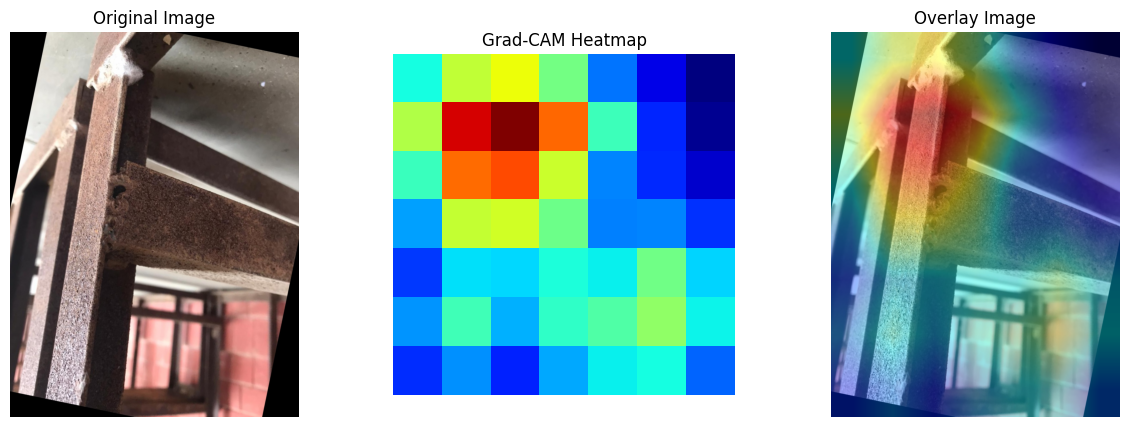

In [42]:
#  Run Grad-CAM 
image_path = "/kaggle/input/defect-datw/test-20250312T172147Z-001/test/images/augmented_aug_0_247_ml.jpg"
show_results(image_path, model)

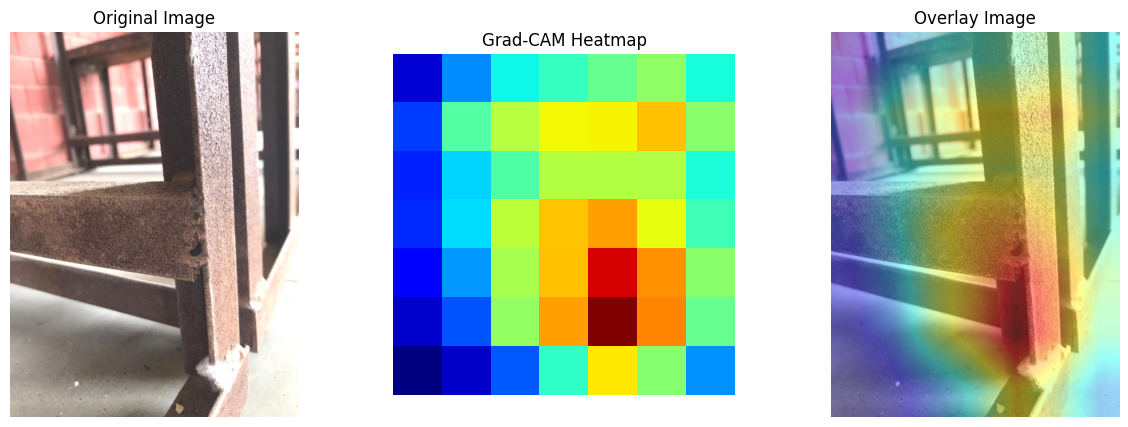

In [45]:
#  Run Grad-CAM 
image_path = "/kaggle/input/defect-datw/test-20250312T172147Z-001/test/images/augmented_aug_0_329_ml.jpg"
show_results(image_path, model)

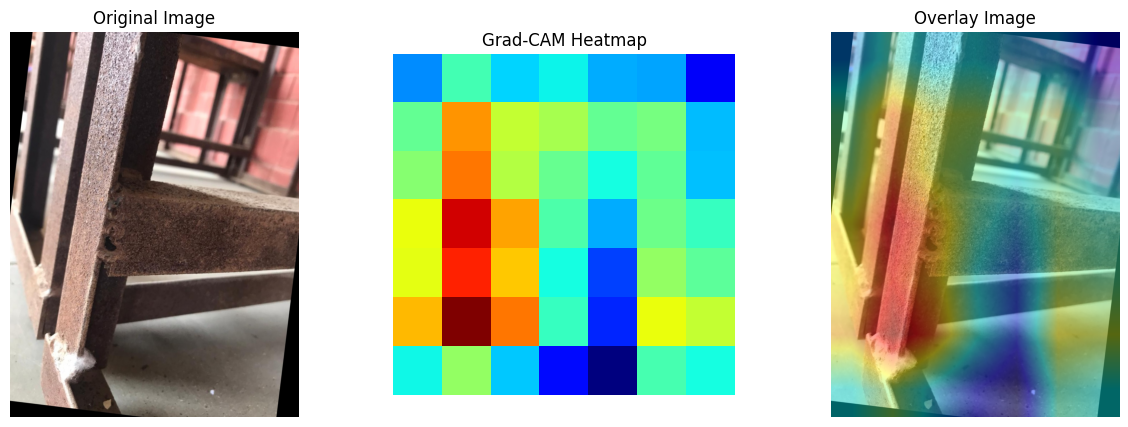

In [24]:

# 🔥 Run Grad-CAM 
image_path = "/kaggle/input/defect-datw/test-20250312T172147Z-001/test/images/augmented_aug_0_153_ml.jpg"  # Change this to your image path
# 🔹 Replace with your image path
show_results(image_path, model)
